In [ ]:
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
!pip install interpret
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt

import yfinance as yahooFinance

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from interpret.blackbox import LimeTabular
from interpret import show
import shap

import math

In [ ]:
#Plotting our Signals on our time period
def plotBuySell(testETH):
  plt.figure(figsize=(16,8))
  plt.scatter(testETH.index, testETH["Buy"], color = "green", label = "Buy", marker = "^", alpha=1)
  plt.scatter(testETH.index, testETH["Sell"], color = "red", label = "Sell", marker = "v", alpha=1)
  plt.plot(testETH.index, testETH["Close"], alpha = 0.5)
  plt.show()

def createBuySell(testETH):
  buysell = buy_sell(testETH, delay)
  testETH["Buy"] = buysell[0]
  testETH["Sell"] = buysell[1]
  #Replacing the first Sell signal by a NaN value
  testETH["Sell"][0] = np.nan
  plotBuySell(testETH)
  return testETH

def performance(data):
    performance = [100]
    num_stocks = 0
    for i in range(len(data)):
        if math.isnan(data["Buy"][i]) == False:
            num_stocks = performance[i]/data["Close"][i]
            performance.append(num_stocks*data["Close"][i])
        elif math.isnan(data["Sell"][i]) == False:
            cash = num_stocks * data["Close"][i]
            performance.append(cash)
        else:
            performance.append(performance[i])


    plt.figure(figsize= (12.6, 4.6))
    plt.plot(performance)
    return performance

def buy_sell(asset, n):
    BuyPrice = []
    SellPrice = []
    flag = -1
    counter = 0

    for i in range(len(asset)):
        if asset["predictedTrade"][i] == 1 and counter == 0:
            if flag != 1:
                BuyPrice.append(asset["Close"][i])
                SellPrice.append(np.nan)
                flag = 1
            else:
                BuyPrice.append(np.nan)
                SellPrice.append(np.nan)
        elif asset["predictedTrade"][i] == -1 and counter ==0:
            if flag !=0:
                BuyPrice.append(np.nan)
                SellPrice.append(asset["Close"][i])
                flag = 0
            else:
                BuyPrice.append(np.nan)
                SellPrice.append(np.nan)
        else:
            BuyPrice.append(np.nan)
            SellPrice.append(np.nan)

        counter +=1
        if counter ==n:
            counter = 0

    return (BuyPrice, SellPrice)

def calc(data):
  truePred = sum(1 for i in range(0,len(data)) if data['predictedTrade'][i] == data['realResult'][i])
  falsePred = sum(1 for i in range(0,len(data)) if data['predictedTrade'][i] != data['realResult'][i])
  all = len(data)
  acc = truePred/all

  print("true: ", truePred)
  print("false: ", falsePred)
  print("all: ", all)
  print("Accurracy: ", acc)

def modelTesterBuyOrSell(data):
  calc(data)
  createBuySell(data)

  test_stock_performance = performance(data)
  print(test_stock_performance[-1])

In [ ]:
#den wievielten Tag er vorhersagen soll
forecastDays = 365
test_days = forecastDays

# wie viele Tage das Modell shiftet für die Vorhersage (in wie viel Tagen steigen oder fallen)
shifter = 30

#wie viele Tage warten, bis Entscheidung geändert werden kann?
delay = 5

# Wie viele Tage davor in eine Zeile!
lag_steps = 30

In [ ]:
ETH = yahooFinance.Ticker("ETH-USD").history(period='max')
ETH_complete = yahooFinance.Ticker("ETH-USD").history(period='max')

In [ ]:
def calculateIndicator(currency, shifter):
  currency["RSI"] = ta.RSI(currency["Close"], timeperiod = 14)
  currency["ROC"] = ta.ROC(currency["Close"], timeperiod = 10)
  currency["%R"] = ta.WILLR(currency["High"], currency["Low"], currency["Close"], timeperiod = 14)
  currency["OBV"] = ta.OBV(currency["Close"], currency["Volume"])
  currency["MACD"], currency["MACD_SIGNAL"], currency["MACD_HIST"] = ta.MACD(currency["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
  #Wenn der Wert in 5 Tagen höher ist, als heute, dann 1, wenn nicht, dann -1 (da genau gleich sehr unwahrscheinlich ist, gilt dies auch als -1)
  currency["realResult"] = np.where(currency["Close"].shift(-shifter) > currency["Close"], 1, -1)
  currency["realValueInXDays"] = currency["Close"].shift(-shifter)

# Anzahl der Verzögerungsschritte (vergangene Tage)
calculateIndicator(ETH, shifter)

#for asset in kryptos:
#  calculateIndicator(asset, shifter)
  #add_lag_features(asset, lag_steps)

def cleanDF(df):
  df = df.drop("Dividends", axis=1)
  df = df.drop("Stock Splits", axis=1)

# Alle anderen Werte löschen, da Algoritmus eher verwirrt -> wahrscheinlich weil hohe Volatilität zur Berechnung bon %R aber wichtig!
 # df = df.drop("High", axis=1)
 # df = df.drop("Low", axis=1)
 # df = df.drop("Open", axis = 1)

  # VOLUMEN ist echt verwirrend für den Algorithmus. Es gibt auch keine Korrelation zwicshen dem Volumen und dem Wert, da SVM sonst nicht geht, wurde es jetzt entfernt!
  df = df.drop("Volume", axis = 1)
  df = df.drop("OBV", axis = 1)
  df.dropna(inplace = True)
  return df

ETH = cleanDF(ETH)
ETH

,Open,High,Low,Close,RSI,ROC,%R,MACD,MACD_SIGNAL,MACD_HIST,realResult,realValueInXDays
Date,,,,,,,,,,,,
2017-12-12 00:00:00+00:00,522.286011,657.317993,504.493988,651.431030,78.063680,40.561534,-2.298922,53.550952,50.810936,2.740015,1,1154.930054
2017-12-13 00:00:00+00:00,644.906006,747.992981,597.797974,702.767029,80.726438,50.855964,-13.042814,66.384639,53.925677,12.458962,1,1273.199951
2017-12-14 00:00:00+00:00,700.593994,753.120972,664.989014,695.815979,79.322406,47.981719,-16.918603,75.128503,58.166242,16.962261,1,1396.420044
2017-12-15 00:00:00+00:00,696.375977,697.132019,621.060974,684.447998,76.964802,47.739275,-20.274861,80.216096,62.576213,17.639883,1,1366.770020
2017-12-16 00:00:00+00:00,686.192017,718.385010,680.786011,696.208984,77.703154,62.442477,-16.802573,84.226156,66.906201,17.319955,1,1291.920044
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-10 00:00:00+00:00,1854.348267,1863.310913,1845.442261,1850.753418,47.726783,-0.291404,-43.032732,-9.929366,-10.007689,0.078323,-1,1635.162354
2023-08-11 00:00:00+00:00,1850.741699,1855.066040,1839.569214,1847.124390,46.828155,-1.317867,-47.523402,-9.344591,-9.875070,0.530479,-1,1616.828857
2023-08-12 00:00:00+00:00,1847.171997,1852.281006,1845.719238,1848.889893,47.347552,0.532882,-44.385480,-8.639105,-9.627877,0.988772,-1,1551.637695


In [ ]:
def trainTestSplitNN(ETH, y):
  # Split train and test
  train_ETH, test_ETH = ETH[0:-forecastDays], ETH[-forecastDays:]

  X = ETH[0:]
  X = X.drop("realResult", axis=1)
  X = X.drop(y, axis = 1)
  X_train = X[: -forecastDays]
  X_test = X[-forecastDays:]

  Y = ETH[y]
  Y_train = Y[: -forecastDays]
  Y_test = Y[-forecastDays:]

  #X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)

  #Erstellen Variable mit letzten <<ForecastDays>> Werten aus dem Dataframe
  prediction_days_array = np.array(ETH['Close'])[-forecastDays:]


  return X_train, X_test, Y_train, Y_test, train_ETH, test_ETH

In [ ]:
X_train, X_test, y_train, y_test, train_ETH, test_ETH = trainTestSplitNN(ETH, 'realValueInXDays')
#X_train, X_test, y_train, y_test, train_ETH, test_ETH = trainTestSplitNN(ETH, 'realResult')
featureNames = ETH.columns
featureNames_X = X_train.columns

X_train, X_test, y_train, y_test, train_ETH, test_ETH = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy(), train_ETH.to_numpy(), test_ETH.to_numpy()


#X= ETH[0:]
#X= X.drop("realResult", axis = 1)
#y = ETH["realResult"]

#testSize = forecastDays/len(ETH)
#X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=testSize, random_state=42)

In [ ]:
model = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(5,),activation='identity', max_iter=10000,learning_rate='adaptive',random_state=0)
)

model.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='identity', hidden_layer_sizes=(5,),
                              learning_rate='adaptive', max_iter=10000,
                              random_state=0))])

In [ ]:
#prediction = model.predict(X_test)

#for i in range(0, len(prediction)):
#  if prediction[i] <= 0:
#    prediction[i] = -1
#  elif prediction[i] >0:
#    prediction[i] = 1

#rmse = np.sqrt(np.mean(prediction-y_test)**2)
#print(rmse)


#train = ETH[: -forecastDays]
#valid = ETH[-forecastDays:]
#valid['predictedTrade'] = prediction



In [ ]:
prediction = model.predict(X_test)

train = ETH[: -forecastDays]
valid = ETH[-forecastDays:]
valid['predicted'] =  prediction
#scaledPred = scaler.inverse_transform(valid)
valid['predictedTrade'] = np.where(valid["predicted"].shift(-shifter) > valid["Close"], 1, -1)

In [ ]:
modelTesterBuyOrSell(valid)

In [ ]:
#X_train = X_train.to_numpy()
explainer = shap.KernelExplainer(model.predict, X_train)

In [ ]:
shap_values = explainer.shap_values(X_test)

  0%|          | 0/365 [00:00<?, ?it/s]

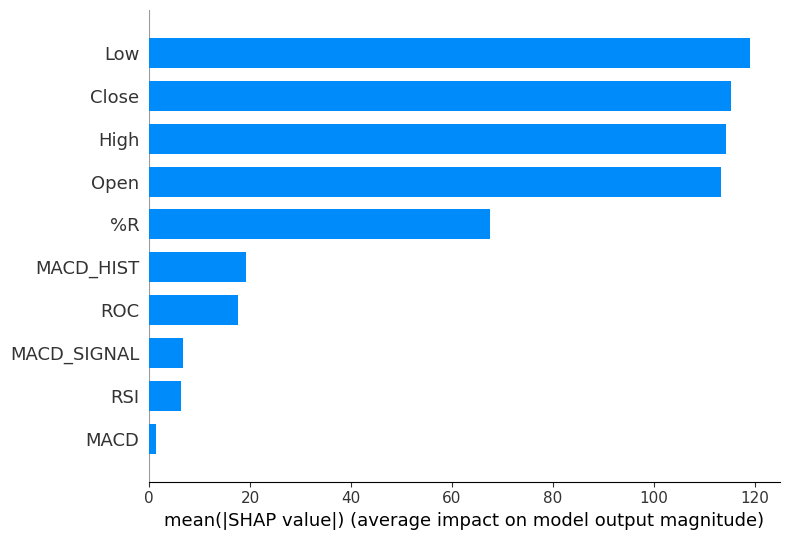

In [ ]:
shapExplainer = shap.summary_plot(
    shap_values,
    X_train,
    feature_names=featureNames_X,
    plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


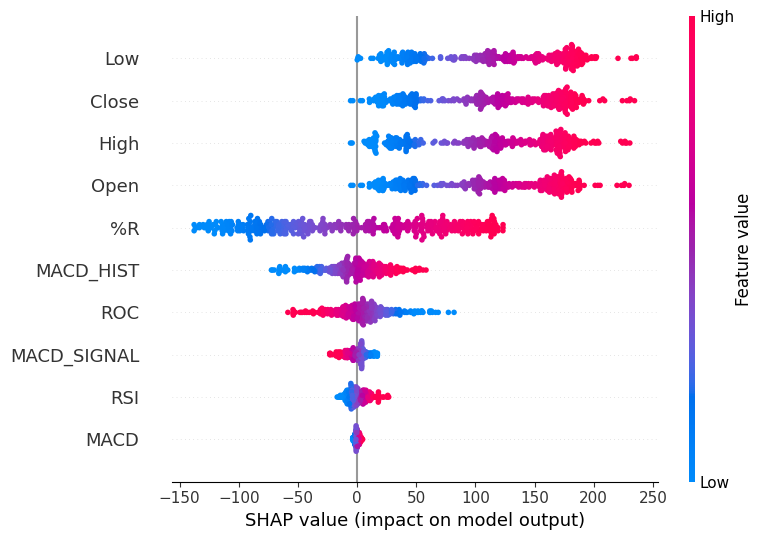

In [ ]:
shap.summary_plot(shap_values,X_test,feature_names=featureNames_X)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:]  ,X_test[0,:],feature_names=featureNames_X)

In [ ]:
def LimeFunction(mlMethod, X_train_data, X_test_data, y_test_data):
    lime2 = LimeTabular(mlMethod, X_train_data, feature_names = featureNames_X)
    lime_local = lime2.explain_local(X_test_data[-20:],y_test_data[-20:], name='LIME')
    show(lime_local)

In [ ]:
# input (Model, X_train, X_test, y_test)
LimeFunction(model, X_train, X_test, y_test)

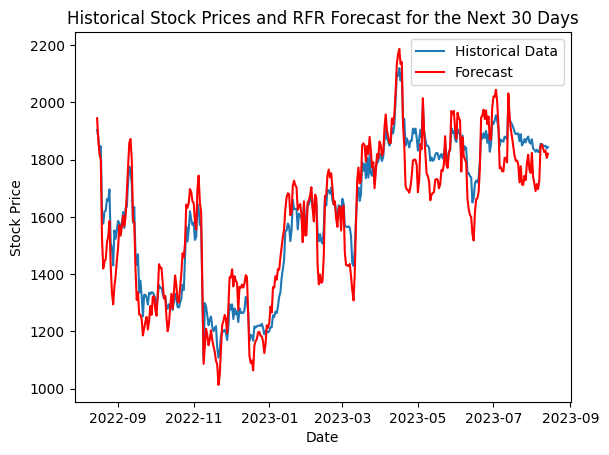

In [ ]:
plt.plot(valid['Close'].shift(0), label='Historical Data')
plt.plot(valid['predicted'], label='Forecast', color='red')
plt.title('Historical Stock Prices and RFR Forecast for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Stock Price')
#plt.xticks(test_data['Date'], rotation = 60)
#plt.xticks(np.arange(0,len(test_ETH), 183), test_ETH.index[0:len(test_ETH):183], rotation = 60)
plt.legend()
plt.show()